In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

from scipy.stats import norm
from scipy import stats

import warnings  
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [221]:
df = pd.read_csv('C:\\Users\\Muhammad Hazim\\bmw.csv')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [222]:
df.isnull().any().any()

False

In [223]:
df.shape

(10781, 9)

In [224]:
df.columns.values

array(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType',
       'tax', 'mpg', 'engineSize'], dtype=object)

In [225]:
num_columns = ['year', 'price', 'mileage','tax', 'mpg', 'engineSize']
cat_columns = ['model', 'transmission',  'fuelType']

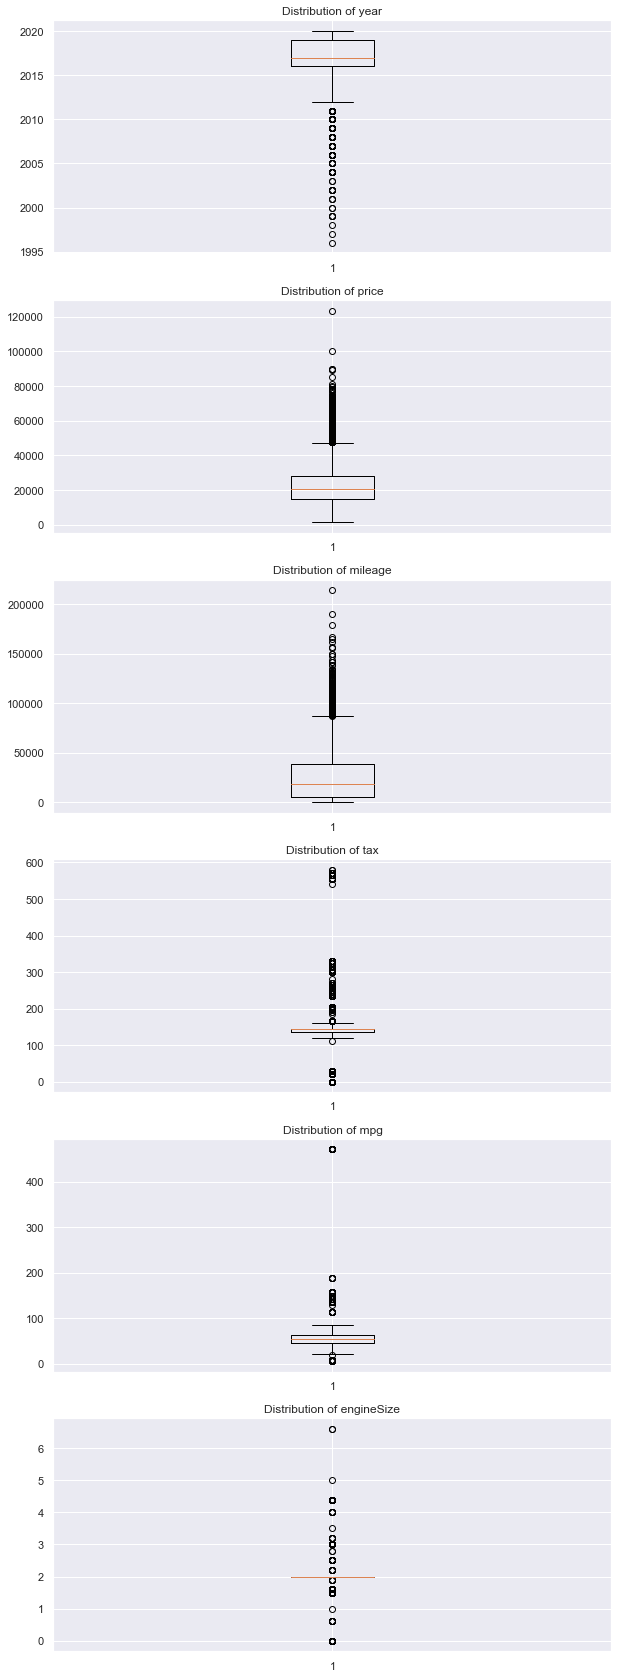

In [226]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 30))
for i in range(6):
    axes[i].boxplot(df[num_columns[i]])
    axes[i].title.set_text('Distribution of '+ num_columns[i])    

In [227]:
df_filtered = df[(df['price']<90000)&(df['mileage']<170000)&(df['tax']<500)&(df['tax']>5)&(df['mpg']<190)&(df['mpg']>2)&(df['engineSize']<5)&(df['engineSize']>1)]
df_filtered.shape

(10370, 9)

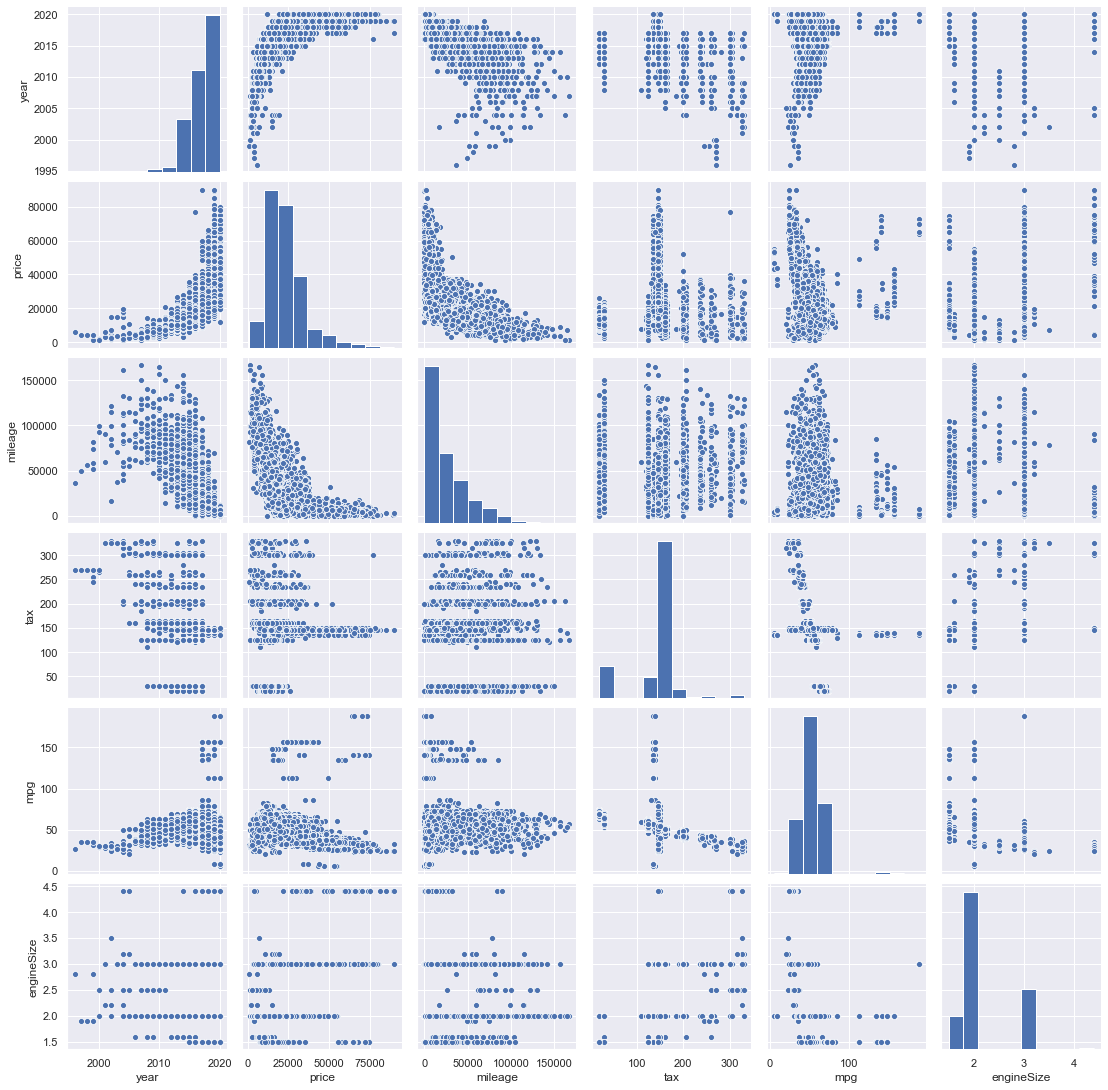

In [228]:
sns.pairplot(df_filtered[num_columns], size = 2.5)
plt.show()

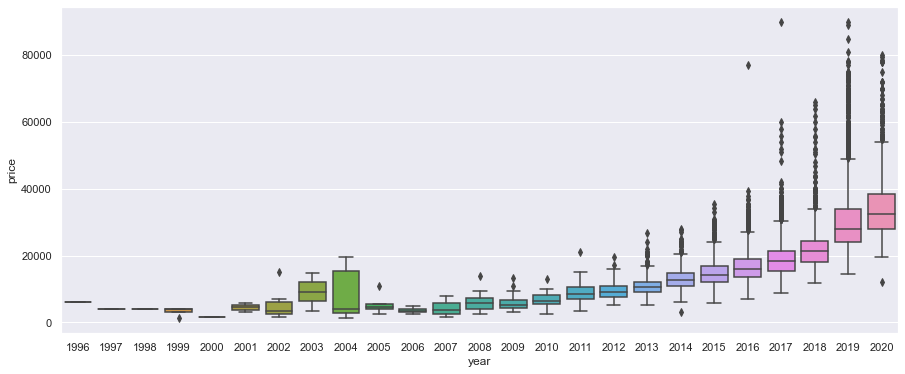

In [229]:
plt.figure(figsize = (15,6))
sns.boxplot(df_filtered['year'],df_filtered['price'])

In [230]:
df_filtered.loc[ df_filtered['year'] <= 2010, 'year'] = 0
for i in range(10):
    df_filtered.loc[ df_filtered['year'] == 2011+i, 'year'] = i+1

In [231]:
df_filtered['year'].value_counts()

9     3485
6     1654
7     1635
5      874
8      844
10     733
4      487
3      345
0      147
2      117
1       49
Name: year, dtype: int64

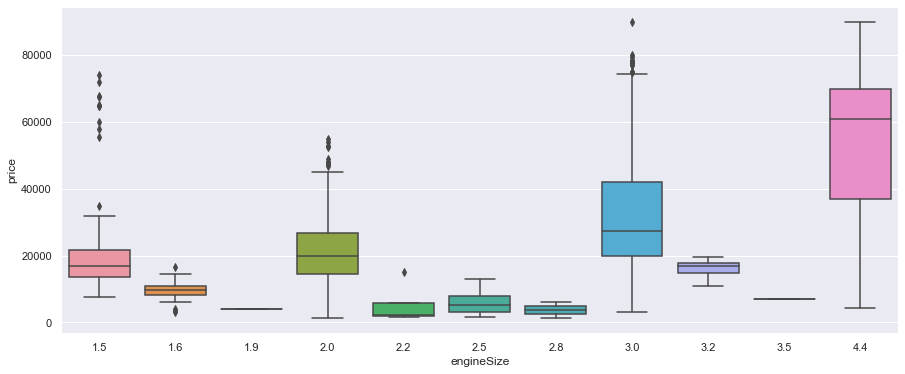

In [232]:
plt.figure(figsize = (15,6))
sns.boxplot(df_filtered['engineSize'],df_filtered['price'])

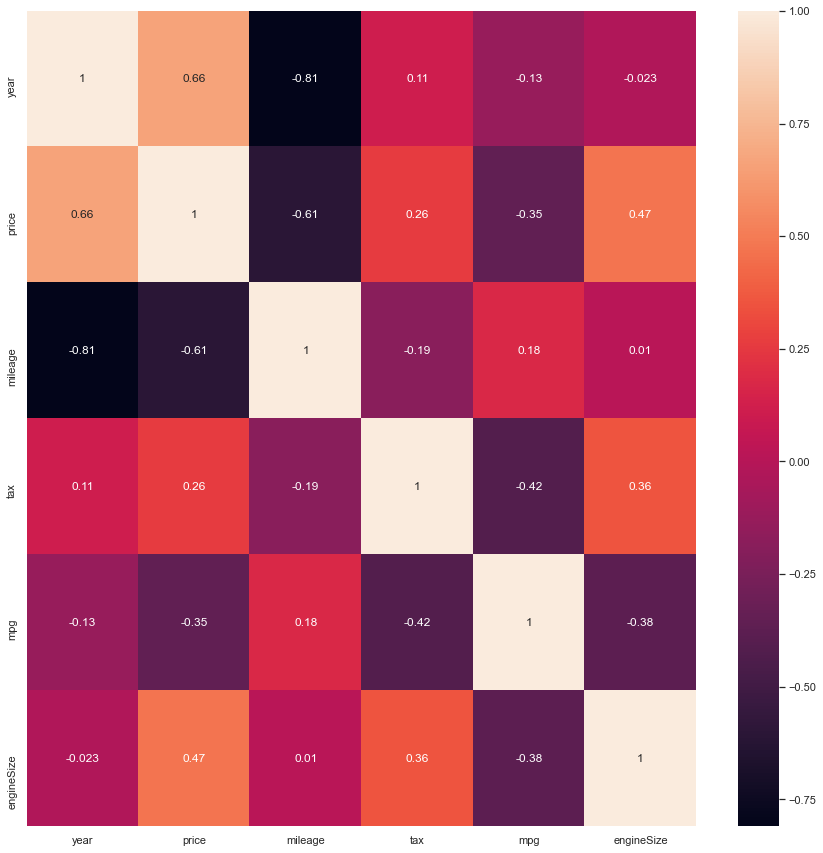

In [233]:
plt.figure(figsize = (15, 15))
sns.heatmap(df_filtered.corr(), annot = True)

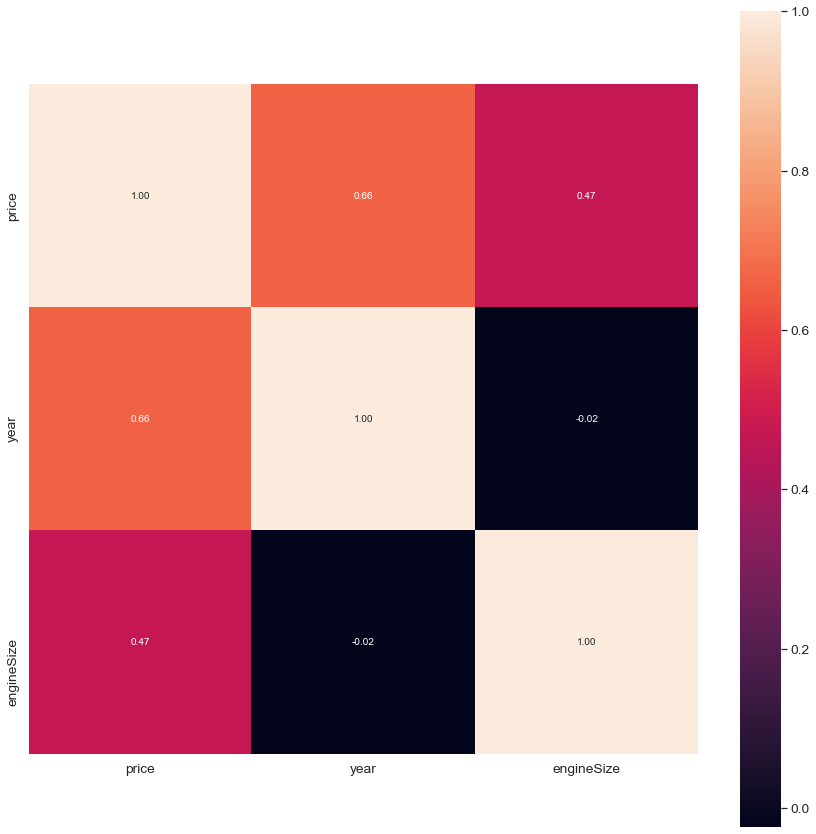

In [234]:
plt.figure(figsize = (15, 15))
k = 3 #number of variables for heatmap
cols = df_filtered.corr().nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_filtered[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [235]:
data = pd.get_dummies(df_filtered, drop_first = True)
data.shape

(10370, 33)

In [236]:
x = data.drop('price', axis = 1)
y= data['price']

In [237]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

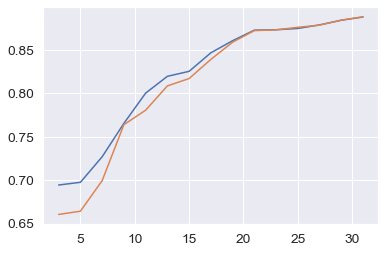

In [238]:
column_names = data.drop('price', axis = 1).columns.values

no_of_features = []
r_squared_train = []
r_squared_test = []

for k in range (3, 33, 2): 
    selector = SelectKBest(f_regression, k=k)
    x_train_transformed = selector.fit_transform(x_train, y_train)
    x_test_transformed = selector.transform(x_test)
    regressor = LinearRegression()
    regressor.fit(x_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(x_train_transformed, y_train))
    r_squared_test.append(regressor.score(x_test_transformed, y_test))
    
sns.lineplot(x = no_of_features, y = r_squared_train, legend = 'full')
sns.lineplot(x = no_of_features, y = r_squared_test, legend = 'full')

In [239]:
selector = SelectKBest(f_regression, k = 21)
x_train_transformed = selector.fit_transform(x_train, y_train)
x_test_transformed = selector.transform(x_test)
column_names[selector.get_support()]

array(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ 2 Series',
       'model_ 3 Series', 'model_ 7 Series', 'model_ 8 Series',
       'model_ M4', 'model_ M5', 'model_ X2', 'model_ X3', 'model_ X4',
       'model_ X5', 'model_ X6', 'model_ X7', 'model_ i8',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Hybrid'],
      dtype=object)

In [240]:
def regression_model(model):
    """
    Will fit the regression model passed and will return the regressor object and the score
    """
    regressor = model
    regressor.fit(x_train_transformed, y_train)
    train_score = regressor.score(x_train_transformed, y_train)
    test_score = regressor.score(x_test_transformed, y_test)
    return regressor, train_score, test_score

In [241]:
model_performance = pd.DataFrame(columns = ["Features", "Model", "Train Score", "Test Score"])

models_to_evaluate = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), CatBoostRegressor()]

for model in models_to_evaluate:
    regressor, train_score, test_score = regression_model(model)
    model_performance = model_performance.append({"Features": "Linear","Model": model, "Train Score": train_score, "Test Score": test_score}, ignore_index=True)

Learning rate set to 0.05688
0:	learn: 10906.6758770	total: 16.3ms	remaining: 16.2s
1:	learn: 10459.3740004	total: 21.8ms	remaining: 10.9s
2:	learn: 10050.6905984	total: 27.4ms	remaining: 9.11s
3:	learn: 9641.0358443	total: 33.1ms	remaining: 8.24s
4:	learn: 9258.0330573	total: 38.5ms	remaining: 7.67s
5:	learn: 8899.1406790	total: 44.1ms	remaining: 7.31s
6:	learn: 8564.7657496	total: 49.8ms	remaining: 7.06s
7:	learn: 8262.5406785	total: 55.2ms	remaining: 6.85s
8:	learn: 7971.2056547	total: 60.6ms	remaining: 6.67s
9:	learn: 7711.8865122	total: 66.3ms	remaining: 6.56s
10:	learn: 7455.8939954	total: 71.9ms	remaining: 6.47s
11:	learn: 7226.6271142	total: 77.5ms	remaining: 6.38s
12:	learn: 7003.4083246	total: 82.9ms	remaining: 6.29s
13:	learn: 6806.9607464	total: 88.3ms	remaining: 6.22s
14:	learn: 6617.5210700	total: 93.7ms	remaining: 6.15s
15:	learn: 6432.7421589	total: 99.3ms	remaining: 6.11s
16:	learn: 6276.7354991	total: 112ms	remaining: 6.5s
17:	learn: 6114.0695835	total: 118ms	remainin

151:	learn: 2876.4682215	total: 817ms	remaining: 4.56s
152:	learn: 2869.2782619	total: 822ms	remaining: 4.55s
153:	learn: 2865.7847411	total: 827ms	remaining: 4.54s
154:	learn: 2860.9421351	total: 832ms	remaining: 4.54s
155:	learn: 2857.4398785	total: 838ms	remaining: 4.53s
156:	learn: 2854.3417463	total: 845ms	remaining: 4.54s
157:	learn: 2851.1392151	total: 850ms	remaining: 4.53s
158:	learn: 2848.1673329	total: 854ms	remaining: 4.52s
159:	learn: 2843.1368982	total: 859ms	remaining: 4.51s
160:	learn: 2839.1935145	total: 864ms	remaining: 4.5s
161:	learn: 2836.3763134	total: 869ms	remaining: 4.49s
162:	learn: 2832.9619445	total: 873ms	remaining: 4.48s
163:	learn: 2828.5013002	total: 878ms	remaining: 4.47s
164:	learn: 2824.2486384	total: 882ms	remaining: 4.46s
165:	learn: 2820.7446676	total: 887ms	remaining: 4.46s
166:	learn: 2817.6200632	total: 892ms	remaining: 4.45s
167:	learn: 2814.2925364	total: 896ms	remaining: 4.44s
168:	learn: 2809.4811599	total: 901ms	remaining: 4.43s
169:	learn:

330:	learn: 2464.8909151	total: 1.68s	remaining: 3.4s
331:	learn: 2463.3807905	total: 1.69s	remaining: 3.4s
332:	learn: 2461.9743418	total: 1.7s	remaining: 3.4s
333:	learn: 2460.9585971	total: 1.7s	remaining: 3.39s
334:	learn: 2459.5959121	total: 1.71s	remaining: 3.39s
335:	learn: 2459.0165177	total: 1.71s	remaining: 3.38s
336:	learn: 2457.6820079	total: 1.72s	remaining: 3.38s
337:	learn: 2456.5564775	total: 1.72s	remaining: 3.37s
338:	learn: 2455.1449984	total: 1.73s	remaining: 3.36s
339:	learn: 2453.7840858	total: 1.73s	remaining: 3.36s
340:	learn: 2452.3764185	total: 1.74s	remaining: 3.35s
341:	learn: 2451.0223937	total: 1.74s	remaining: 3.35s
342:	learn: 2449.8724783	total: 1.74s	remaining: 3.34s
343:	learn: 2449.0503283	total: 1.75s	remaining: 3.34s
344:	learn: 2447.7028877	total: 1.75s	remaining: 3.33s
345:	learn: 2446.2990449	total: 1.76s	remaining: 3.33s
346:	learn: 2445.2123104	total: 1.76s	remaining: 3.32s
347:	learn: 2444.0041264	total: 1.77s	remaining: 3.31s
348:	learn: 244

503:	learn: 2292.4652655	total: 2.53s	remaining: 2.49s
504:	learn: 2291.7714608	total: 2.54s	remaining: 2.48s
505:	learn: 2291.0301997	total: 2.54s	remaining: 2.48s
506:	learn: 2290.5230772	total: 2.54s	remaining: 2.48s
507:	learn: 2289.6996878	total: 2.55s	remaining: 2.47s
508:	learn: 2288.9280428	total: 2.56s	remaining: 2.47s
509:	learn: 2288.4764083	total: 2.56s	remaining: 2.46s
510:	learn: 2287.3746560	total: 2.57s	remaining: 2.46s
511:	learn: 2286.6163920	total: 2.57s	remaining: 2.45s
512:	learn: 2286.2982174	total: 2.58s	remaining: 2.45s
513:	learn: 2285.5984682	total: 2.58s	remaining: 2.44s
514:	learn: 2284.8796152	total: 2.59s	remaining: 2.44s
515:	learn: 2284.0648879	total: 2.59s	remaining: 2.43s
516:	learn: 2282.6823620	total: 2.6s	remaining: 2.42s
517:	learn: 2281.6515905	total: 2.6s	remaining: 2.42s
518:	learn: 2280.7435172	total: 2.6s	remaining: 2.41s
519:	learn: 2280.0519429	total: 2.61s	remaining: 2.41s
520:	learn: 2278.3693514	total: 2.61s	remaining: 2.4s
521:	learn: 22

671:	learn: 2187.1298668	total: 3.37s	remaining: 1.65s
672:	learn: 2186.8016666	total: 3.38s	remaining: 1.64s
673:	learn: 2186.1457082	total: 3.38s	remaining: 1.64s
674:	learn: 2185.8968564	total: 3.39s	remaining: 1.63s
675:	learn: 2185.6234391	total: 3.4s	remaining: 1.63s
676:	learn: 2184.8813133	total: 3.4s	remaining: 1.62s
677:	learn: 2184.6130095	total: 3.41s	remaining: 1.62s
678:	learn: 2182.3441127	total: 3.41s	remaining: 1.61s
679:	learn: 2182.0385675	total: 3.42s	remaining: 1.61s
680:	learn: 2181.8082832	total: 3.42s	remaining: 1.6s
681:	learn: 2181.6167841	total: 3.43s	remaining: 1.6s
682:	learn: 2180.9175293	total: 3.43s	remaining: 1.59s
683:	learn: 2179.8592607	total: 3.44s	remaining: 1.59s
684:	learn: 2179.4799145	total: 3.44s	remaining: 1.58s
685:	learn: 2179.2345864	total: 3.45s	remaining: 1.58s
686:	learn: 2178.4932996	total: 3.45s	remaining: 1.57s
687:	learn: 2178.1239797	total: 3.46s	remaining: 1.57s
688:	learn: 2177.4850828	total: 3.46s	remaining: 1.56s
689:	learn: 21

842:	learn: 2099.1083607	total: 4.23s	remaining: 788ms
843:	learn: 2097.9787408	total: 4.23s	remaining: 783ms
844:	learn: 2097.7486501	total: 4.24s	remaining: 778ms
845:	learn: 2097.4078431	total: 4.24s	remaining: 773ms
846:	learn: 2096.6254257	total: 4.25s	remaining: 768ms
847:	learn: 2096.3970740	total: 4.25s	remaining: 763ms
848:	learn: 2096.0326103	total: 4.26s	remaining: 758ms
849:	learn: 2095.5346674	total: 4.26s	remaining: 753ms
850:	learn: 2095.0767668	total: 4.27s	remaining: 748ms
851:	learn: 2094.4103834	total: 4.27s	remaining: 743ms
852:	learn: 2094.2308533	total: 4.28s	remaining: 737ms
853:	learn: 2093.3322502	total: 4.28s	remaining: 732ms
854:	learn: 2092.7316624	total: 4.29s	remaining: 727ms
855:	learn: 2092.5648746	total: 4.29s	remaining: 722ms
856:	learn: 2091.2790880	total: 4.3s	remaining: 717ms
857:	learn: 2091.0634890	total: 4.3s	remaining: 712ms
858:	learn: 2090.8258761	total: 4.31s	remaining: 707ms
859:	learn: 2090.5675571	total: 4.31s	remaining: 702ms
860:	learn: 

999:	learn: 2037.2101590	total: 5.08s	remaining: 0us


In [242]:
model_performance

,Features,Model,Train Score,Test Score
0,Linear,LinearRegression(),0.872736,0.872190
1,Linear,DecisionTreeRegressor(),0.999217,0.912014
2,Linear,"(DecisionTreeRegressor(max_features='auto', ra...",0.992266,0.944138
3,Linear,<catboost.core.CatBoostRegressor object at 0x0...,0.968038,0.953115


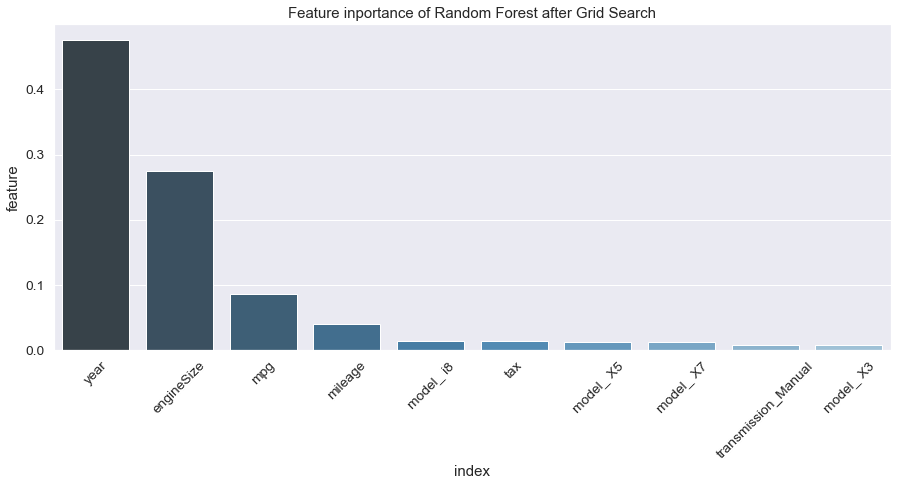

In [243]:
def build_feature_importance(model, x_train, y_train):
    
    models = model
    models.fit(x_train, y_train)
    data = pd.DataFrame(models.feature_importances_, x_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[15,6])
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature inportance of Random Forest after Grid Search')
    plt.xticks(rotation=45)
    plt.show();
    
build_feature_importance(RandomForestRegressor(), x_train, y_train)

In [244]:
df_filtered[['model','price']].groupby(['model']).agg(['mean','median','max','min','count']).sort_values(by=('price','mean'), ascending = False).reset_index()

model         price                             
                       mean   median    max    min count
0          X7  69842.763636  69146.0  79566  59988    55
1          M5  68799.095238  68930.0  89900  58991    21
2          i8  64945.100000  64865.0  74226  55485    10
3    8 Series  63997.794872  61898.0  88980  51980    39
4          M6  46995.000000  46995.0  46995  46995     1
5          X6  43901.759615  40207.0  69995  13440   104
6          M2  43140.333333  44990.0  49999  23495    21
7          M4  42817.169355  43240.0  89990  26499   124
8          X5  40215.497748  44875.0  73000   7998   444
9    7 Series  36612.504854  36450.0  59995   4995   103
10         M3  33393.333333  34269.0  62995  10999    21
11         X4  32721.335196  34995.0  60995  15199   179
12         X2  28486.663194  27989.5  44980  19240   288
13         X3  27799.707273  29418.5  69991   3495   550
14         Z4  27001.935185  30995.0  50800   1995   108
15   6 Series  24465.075472  22854.0  52500   4995   106
16   5 Series  22560.662226  22998.0  54845   1595  1051
17   4 Series  22498.418090  21975.0  48155   8500   995
18   3 Series  20072.387677  18690.0  71990   1200  2337
19         X1  19816.564677  19042.5  37320   5994   804
20   2 Series  19600.881032  19990.0  37989   5895  1202
21   1 Series  16338.931111  15340.5  38555   1500  1800
22         Z3   5826.428571   3995.0  14995   3950     7

In [245]:
df_filtered[['transmission','price']].groupby(['transmission']).agg(['mean','median','max','min','count']).sort_values(by=('price','mean'), ascending = False).reset_index()

transmission         price                            
                        mean   median    max   min count
0    Semi-Auto  27408.189341  24995.0  89990  5299  4616
1    Automatic  22544.173133  19579.5  78386  1200  3402
2       Manual  14960.338435  13995.0  46000  1445  2352